In [20]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

In [21]:
open_air = pd.read_csv('open_air.csv')
acrylic_glass = pd.read_csv('acrylic_glass.csv')
wood = pd.read_csv('wood.csv')

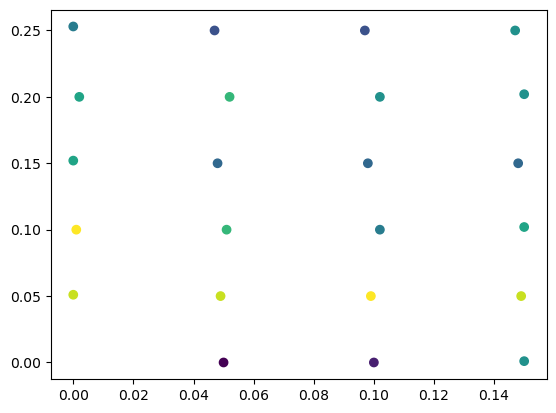

In [22]:
plt.scatter(wood['x_m'], wood['y_m'], c=wood["RSSI"], cmap='viridis', label='Wood', alpha=1)

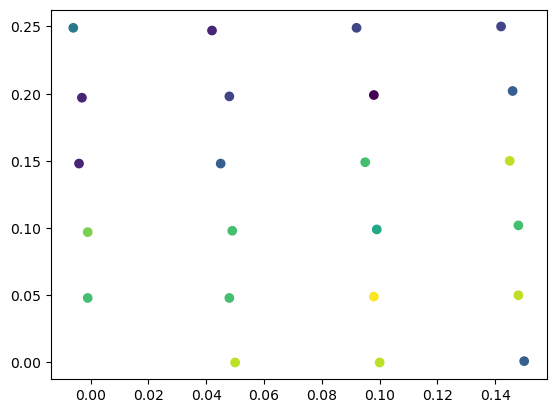

In [23]:
plt.scatter(acrylic_glass['x_m'], acrylic_glass['y_m'], c=acrylic_glass["RSSI"], cmap='viridis', label='Glass', alpha=1)

In [24]:
from scipy import stats

air = open_air['RSSI'].tolist()
wood_list = wood['RSSI'].tolist()
glass = acrylic_glass['RSSI'].tolist()

f_stat, p_val = stats.f_oneway(air, wood_list, glass)
print(f"F={f_stat:.2f}, p={p_val:.4f}")

F=4.55, p=0.0141


In [25]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd

rssi_values = air + wood_list + glass
materials = (['air'] * len(air)) + (['wood'] * len(wood_list)) + (['acrylic'] * len(glass))

df = pd.DataFrame({
    'RSSI': rssi_values,
    'Material': materials
})

tukey = pairwise_tukeyhsd(
    endog=df['RSSI'],        
    groups=df['Material'],   
    alpha=0.05
)

print(tukey.summary())


 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
acrylic    air   2.1739 0.0803 -0.2059  4.5538  False
acrylic   wood  -0.6957 0.7638 -3.0755  1.6842  False
    air   wood  -2.8696 0.0142 -5.2494 -0.4897   True
-----------------------------------------------------


In [26]:
open_air_mean = open_air['RSSI'].mean()
acrylic_glass_mean = acrylic_glass['RSSI'].mean()
wood_mean = wood['RSSI'].mean()
print(f"Open Air Mean RSSI: {open_air_mean:.2f}")
print(f"Acrylic Glass Mean RSSI: {acrylic_glass_mean:.2f}")
print(f"Wood Mean RSSI: {wood_mean:.2f}")

Open Air Mean RSSI: -60.74
Acrylic Glass Mean RSSI: -62.91
Wood Mean RSSI: -63.61


Estimated P0: -70.41 dBm
Estimated path loss exponent n: 0.91
R² score: 0.3821


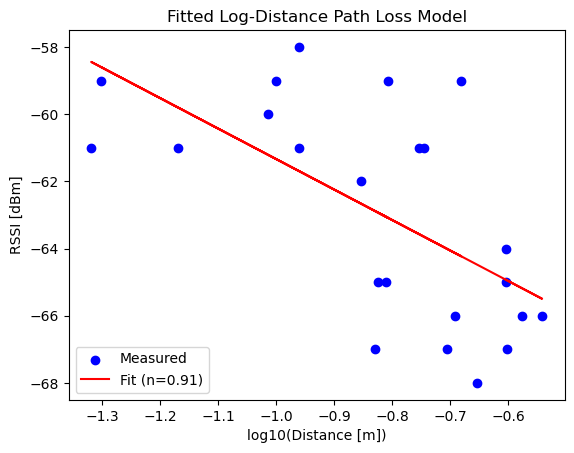

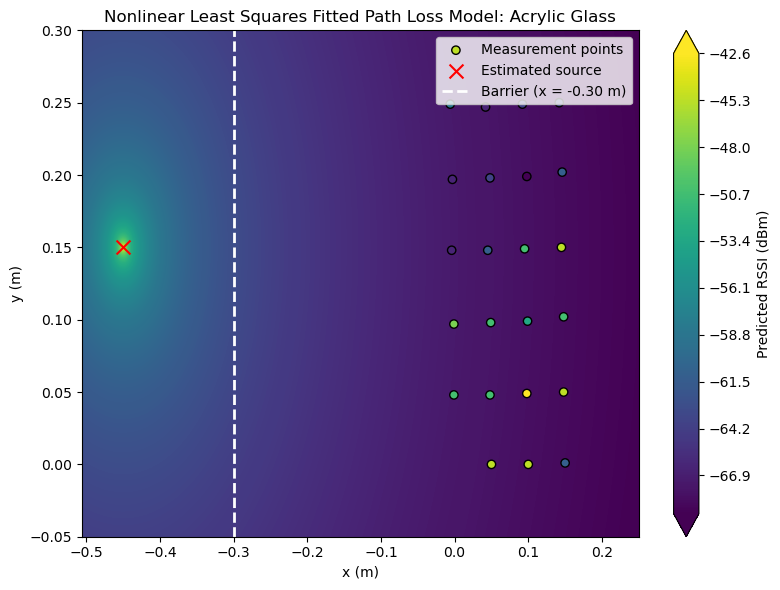

In [27]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  

x = acrylic_glass["x_m"].values
y = acrylic_glass["y_m"].values
rssi = acrylic_glass["RSSI"].values
XY = np.column_stack((x, y))

xs_true, ys_true = 0.0, 0.0   
xs_est, ys_est = -0.45, 0.15   
def path_loss_residuals(params, XY, rssi, xs, ys):
    P0, n = params
    x, y = XY[:,0], XY[:,1]
    d = np.sqrt((x - xs)**2 + (y - ys)**2)
    d[d < 1e-6] = 1e-6 
    pred = P0 - 10 * n * np.log10(d)
    return pred - rssi

initial_guess = [np.max(rssi), 2.0]
bounds = ([-100, 0.5], [0, 6.0])

res = least_squares(path_loss_residuals, initial_guess, args=(XY, rssi, xs_true, ys_true), bounds=bounds)
P0_est, n_est = res.x
print(f"Estimated P0: {P0_est:.2f} dBm")
print(f"Estimated path loss exponent n: {n_est:.2f}")

d = np.sqrt((x - xs_true)**2 + (y - ys_true)**2)
rssi_pred = P0_est - 10 * n_est * np.log10(d)

r2 = r2_score(rssi, rssi_pred) 
print(f"R² score: {r2:.4f}")
plt.scatter(np.log10(d), rssi, label="Measured", color="blue")
plt.plot(np.log10(d), P0_est - 10 * n_est * np.log10(d), color="red", label=f"Fit (n={n_est:.2f})")
plt.xlabel("log10(Distance [m])")
plt.ylabel("RSSI [dBm]")
plt.legend()
plt.title("Fitted Log-Distance Path Loss Model")
plt.show()

xi = np.linspace(XY[:,0].min() - 0.5, XY[:,0].max() + 0.1, 400)
yi = np.linspace(XY[:,1].min() - 0.05, XY[:,1].max() + 0.05, 400)
xi, yi = np.meshgrid(xi, yi)

d_grid = np.sqrt((xi - xs_est)**2 + (yi - ys_est)**2)
d_grid[d_grid < 1e-6] = 1e-6
zi = P0_est - 10 * n_est * np.log10(d_grid)

plt.figure(figsize=(8,6))
contour = plt.contourf(xi, yi, zi, levels=300, cmap='viridis', extend='both')

plt.scatter(x, y, c=rssi, cmap='viridis', edgecolor='k', label='Measurement points')
plt.scatter(xs_est, ys_est, color='red', marker='x', s=100, label='Estimated source')

plt.axvline(x=-0.30, color='white', linestyle='--', linewidth=2, label='Barrier (x = -0.30 m)')

plt.colorbar(contour, label="Predicted RSSI (dBm)")
plt.legend(loc='upper right')
plt.title("Nonlinear Least Squares Fitted Path Loss Model: Acrylic Glass")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()

Estimated P0: -67.71 dBm
Estimated path loss exponent n: 0.50
R² score: 0.0529


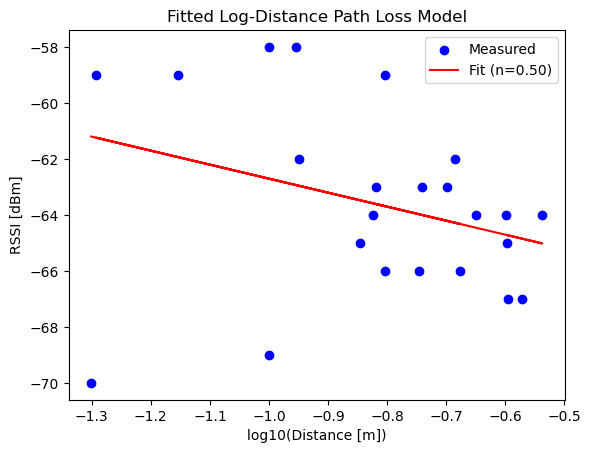

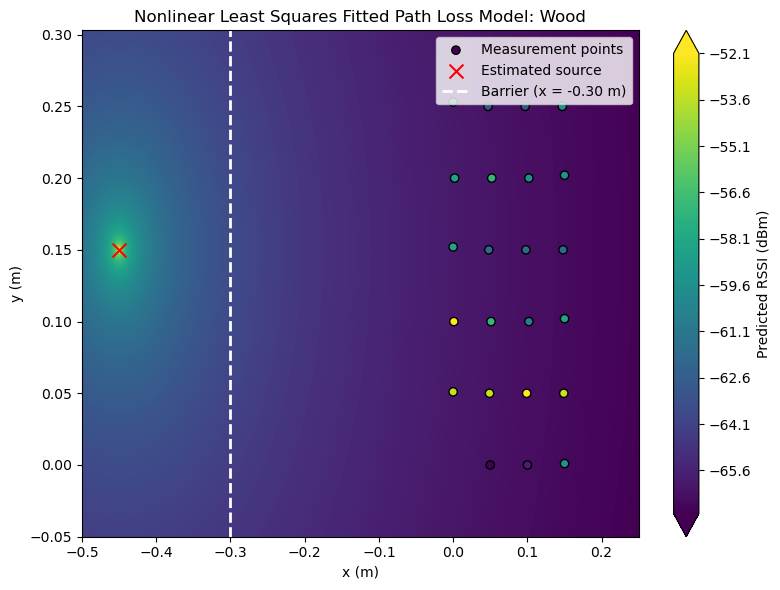

In [28]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  

x = wood["x_m"].values
y = wood["y_m"].values
rssi = wood["RSSI"].values
XY = np.column_stack((x, y))

xs_true, ys_true = 0.0, 0.0   
xs_est, ys_est = -0.45, 0.15   
def path_loss_residuals(params, XY, rssi, xs, ys):
    P0, n = params
    x, y = XY[:,0], XY[:,1]
    d = np.sqrt((x - xs)**2 + (y - ys)**2)
    d[d < 1e-6] = 1e-6 
    pred = P0 - 10 * n * np.log10(d)
    return pred - rssi

initial_guess = [np.max(rssi), 2.0]
bounds = ([-100, 0.5], [0, 6.0])

res = least_squares(path_loss_residuals, initial_guess, args=(XY, rssi, xs_true, ys_true), bounds=bounds)
P0_est, n_est = res.x
print(f"Estimated P0: {P0_est:.2f} dBm")
print(f"Estimated path loss exponent n: {n_est:.2f}")

d = np.sqrt((x - xs_true)**2 + (y - ys_true)**2)
rssi_pred = P0_est - 10 * n_est * np.log10(d)

r2 = r2_score(rssi, rssi_pred) 
print(f"R² score: {r2:.4f}")
plt.scatter(np.log10(d), rssi, label="Measured", color="blue")
plt.plot(np.log10(d), P0_est - 10 * n_est * np.log10(d), color="red", label=f"Fit (n={n_est:.2f})")
plt.xlabel("log10(Distance [m])")
plt.ylabel("RSSI [dBm]")
plt.legend()
plt.title("Fitted Log-Distance Path Loss Model")
plt.show()

xi = np.linspace(XY[:,0].min() - 0.5, XY[:,0].max() + 0.1, 400)
yi = np.linspace(XY[:,1].min() - 0.05, XY[:,1].max() + 0.05, 400)
xi, yi = np.meshgrid(xi, yi)

d_grid = np.sqrt((xi - xs_est)**2 + (yi - ys_est)**2)
d_grid[d_grid < 1e-6] = 1e-6
zi = P0_est - 10 * n_est * np.log10(d_grid)

plt.figure(figsize=(8,6))
contour = plt.contourf(xi, yi, zi, levels=300, cmap='viridis', extend='both')

plt.scatter(x, y, c=rssi, cmap='viridis', edgecolor='k', label='Measurement points')
plt.scatter(xs_est, ys_est, color='red', marker='x', s=100, label='Estimated source')

plt.axvline(x=-0.30, color='white', linestyle='--', linewidth=2, label='Barrier (x = -0.30 m)')

plt.colorbar(contour, label="Predicted RSSI (dBm)")
plt.legend(loc='upper right')
plt.title("Nonlinear Least Squares Fitted Path Loss Model: Wood")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()

Estimated P0: -68.37 dBm
Estimated path loss exponent n: 0.93
R² score: 0.3399


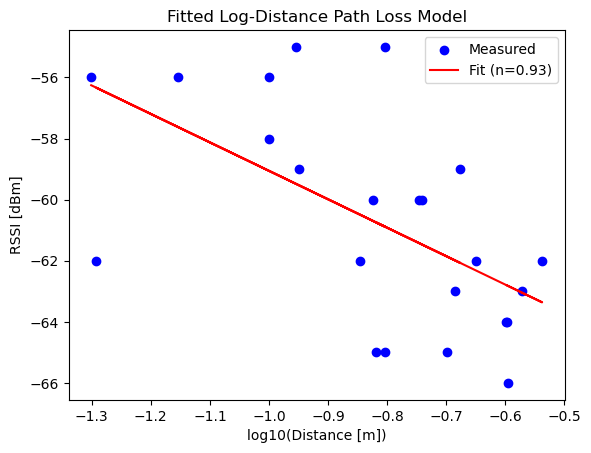

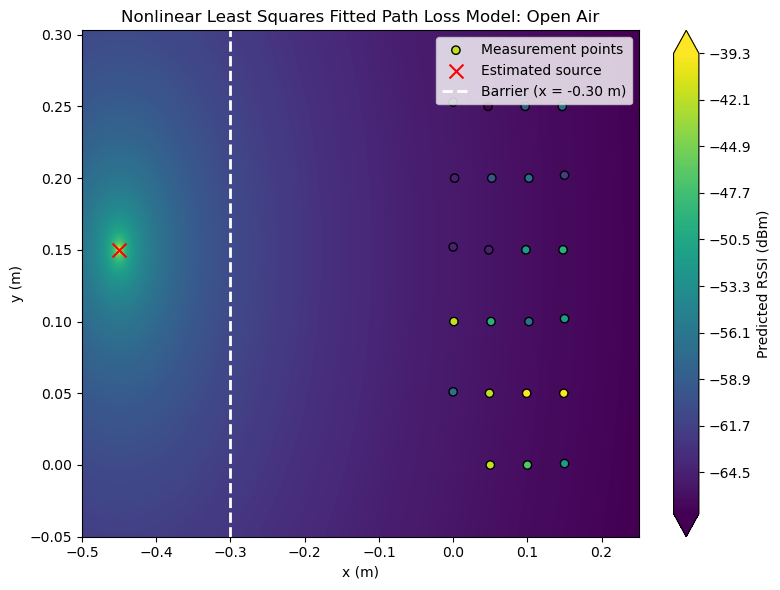

In [29]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  

x = open_air["x_m"].values
y = open_air["y_m"].values
rssi = open_air["RSSI"].values
XY = np.column_stack((x, y))

xs_true, ys_true = 0.0, 0.0   
xs_est, ys_est = -0.45, 0.15   
def path_loss_residuals(params, XY, rssi, xs, ys):
    P0, n = params
    x, y = XY[:,0], XY[:,1]
    d = np.sqrt((x - xs)**2 + (y - ys)**2)
    d[d < 1e-6] = 1e-6 
    pred = P0 - 10 * n * np.log10(d)
    return pred - rssi

initial_guess = [np.max(rssi), 2.0]
bounds = ([-100, 0.5], [0, 6.0])

res = least_squares(path_loss_residuals, initial_guess, args=(XY, rssi, xs_true, ys_true), bounds=bounds)
P0_est, n_est = res.x
print(f"Estimated P0: {P0_est:.2f} dBm")
print(f"Estimated path loss exponent n: {n_est:.2f}")

d = np.sqrt((x - xs_true)**2 + (y - ys_true)**2)
rssi_pred = P0_est - 10 * n_est * np.log10(d)

r2 = r2_score(rssi, rssi_pred) 
print(f"R² score: {r2:.4f}")
plt.scatter(np.log10(d), rssi, label="Measured", color="blue")
plt.plot(np.log10(d), P0_est - 10 * n_est * np.log10(d), color="red", label=f"Fit (n={n_est:.2f})")
plt.xlabel("log10(Distance [m])")
plt.ylabel("RSSI [dBm]")
plt.legend()
plt.title("Fitted Log-Distance Path Loss Model")
plt.show()

xi = np.linspace(XY[:,0].min() - 0.5, XY[:,0].max() + 0.1, 400)
yi = np.linspace(XY[:,1].min() - 0.05, XY[:,1].max() + 0.05, 400)
xi, yi = np.meshgrid(xi, yi)

d_grid = np.sqrt((xi - xs_est)**2 + (yi - ys_est)**2)
d_grid[d_grid < 1e-6] = 1e-6
zi = P0_est - 10 * n_est * np.log10(d_grid)

plt.figure(figsize=(8,6))
contour = plt.contourf(xi, yi, zi, levels=300, cmap='viridis', extend='both')

plt.scatter(x, y, c=rssi, cmap='viridis', edgecolor='k', label='Measurement points')
plt.scatter(xs_est, ys_est, color='red', marker='x', s=100, label='Estimated source')

plt.axvline(x=-0.30, color='white', linestyle='--', linewidth=2, label='Barrier (x = -0.30 m)')

plt.colorbar(contour, label="Predicted RSSI (dBm)")
plt.legend(loc='upper right')
plt.title("Nonlinear Least Squares Fitted Path Loss Model: Open Air")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.tight_layout()
plt.show()